In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import warnings

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import pos_tag

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, plot_roc_curve, precision_score, recall_score \
,f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


# 1. Problem Statement
---

To eliminate Fake News in Reddit Subreddit to avoid being posted by the malicious people to delude or take advantage of the fake news such as political or diplomatic activities.

**Why does ‘Fake News’ matters?**
1. More than 26.0 % SHARE OF AMERICAN VERY CONFIDENT IN THEIR ABILITY TO RECOGNIZE FAKE.
2. 67.0 % AMERICANS WHO BELIEVE FAKE NEWS CAUSES A GREAT DEAL OF CONFUSION.
3. 38.2 %AMERICANS WHO ACCIDENTALLY SHARED FAKE NEWS.

# 2. Create Fuctions
---

In [2]:
def compare_words(corpus, compare_col, top_num, token=True, stop_words=None, n_grame=(1,1)):
    """Fuction to compare common words from given data and a column that need to compare,
    visualizing by holizontal bar chart
    
    Parameters:
    corpus: Dataframe
    compare_col: Column name that use to compare common words in datafram
    top_num: Maximum number of common words shown
    token: Boolean if given dataframe was tokenized. Default: True
    stop_words: List of words that need to be excluded
    n_grame: Number of word(s) that want to tokenize"""
    
    # prepare data
    if token == False:
        cvec = CountVectorizer(stop_words=stop_words, ngram_range=n_grame)
        data = pd.DataFrame(cvec.fit_transform(corpus['title']).todense(), columns=cvec.get_feature_names_out())
        data[compare_col] = corpus[compare_col]
    else:
        data = corpus
    
    # prepare chart
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    cols_used = data.columns.to_list()
    cols_used.remove(compare_col)
    
    # plot axs[0]
    data[cols_used].sum().sort_values(ascending=False)[:top_num].sort_values().plot(kind='barh', ax=axs[0], color = 'grey')
    axs[0].set_title('Overall Common Words', fontsize=18)
    
    # plot axs[1]
    data[data[compare_col] == 'fake_news'][cols_used].sum().sort_values(ascending=False)[:top_num].sort_values().plot(kind='barh', ax=axs[1], color='red')
    axs[1].set_title('Fake News Common Words', fontsize=18)
    plt.yticks(fontsize=20)
    
    # plot axs[2]
    data[data[compare_col] == 'real_news'][cols_used].sum().sort_values(ascending=False)[:top_num].sort_values().plot(kind='barh', ax=axs[2], color='darkblue')
    axs[2].set_title('Real News Common Words', fontsize=16)
    plt.yticks(fontsize=20)
    
    for a in axs.flatten():
        a.tick_params(axis='y', which='major', labelsize=15)
    
    plt.tight_layout()

In [3]:
def metrics(func):
    """Fuction that returns evaluation matrics from given model."""
    warnings.filterwarnings('ignore')
    print(f"Train Accuracy : {func.score(X_train,y_train)}")
    print(f"Test Accuracy : {func.score(X_test,y_test)}",end="\n\n")
    print("Train Classification Report",end="\n\n")
    y_pred_train = func.predict(X_train)
    print(classification_report(y_train,y_pred_train),end="\n\n\n")
    print("Test Classification Report",end="\n\n")
    y_pred = func.predict(X_test)
    print(classification_report(y_test,y_pred),end="\n\n")
    plot_roc_curve(func, X_test, y_test)
    plt.plot(y_test,y_test,"--")
    plt.title('ROC CURVE')
    warnings.resetwarnings()

In [4]:
def compare_models(models_list):
    """Return dataframe of models result from list of models"""
    df = pd.DataFrame(columns=['model', 'model_name', 'vectorizor', 'acc_train', 'acc_test'])
    for i in range(len(models_list)):
        df.loc[i] = [models_list[i],
                      str(models_list[i].get_params()['estimator__steps'][1][1]),
                      str(models_list[i].get_params()['estimator__steps'][0][1]),
                      models_list[i].score(X_train, y_train),
                      models_list[i].score(X_test, y_test)
                     ]
    return df

In [5]:
def plot_confusion(model, X_test):
    """Function to plot confusion matrix from given model and X_test"""
    y_preds = model.predict(X_test)
    cm = confusion_matrix(y_test, y_preds)
    tn, fp, fn, tp = cm.ravel()
    ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=model.classes_).plot();

In [6]:
def print_news(data, keywords):
    """Function returns specific documents 
    matching by given keywords. Given keywords can be formatted as regular expression"""
    for i in range(len(data[data['title'].str.lower().str.contains(keywords)])):
        print('----------------')
        print(f"{data[data['title'].str.lower().str.contains(keywords)]['class_news'].iloc[i]}:")
        print(data[data['title'].str.lower().str.contains(keywords)]['title'].iloc[i])

In [7]:
# Testing model function
def test_news(model, text):
    """Prediction of given text from fit model"""
    print('Predicting...')
    pred = model.predict(pd.Series(text))
    print(f'Input: {text}')
    print(f'Prediction: {"Fake news" if pred[0] == 1 else "Real news"}')

In [8]:
def incorrect_df(model, X_test, X_test_cvec, y_test):
    """Function returns a dataframe for incorrectly predicted data
    Parameters:
    X_test: Dataframe before tokenizing
    X_test_cven: Dataframe after tokenizing
    **If the model can automatically tokenize words, 
    X_test and X_test_cvec have to be untokenized corpus**"""
# Dataframe for testing set
    df = pd.DataFrame(X_test)
    df['actual_class'] = y_test
    df['predict_class'] = model.predict(X_test_cvec)
    df = df[df['actual_class'] != df['predict_class']].sort_values(by='predict_class').reset_index(drop=True)
    return(df)

In [9]:
# Fuction to print incorrectly predicted data
def print_false(df):
    """Fuction to print fale negatives and positives documents
    from given df (df must be functioned by incorrect_df fuction)"""
    df_negative = df[df['predict_class'] == 0].reset_index(drop=True)
    df_positive = df[df['predict_class'] == 1].reset_index(drop=True)
    # False negatives
    print("""---------- False Negatives -----------
Prediction: Real news
Actual: Fake news
""")
    for i in range(len(df_negative)):
        print(df_negative['title'].iloc[i])
        print('-----')

    # False positives
    print("""\n---------- False Positives -----------
Prediction: Fake news
Actual: Real news
""")
    for i in range(len(df_positive)):
        print(df_positive['title'].iloc[i])
        print('-----')

In [10]:
def shorten_words(df, col, shortenizer='lem'):
    """Shorten text in dataframe by given shortenizer and return result as dataframe.
    
    shortenizer options: lem (default), stem
    lem = WordNetLemmatizer()
    stem = PorterStemmer()"""
    
    data = df.copy()
    if shortenizer == 'lem':
        lem = WordNetLemmatizer()
        data[col] = data[col].apply(lambda x: (" ").join([lem.lemmatize(word) for word in x.split()]))
    elif shortenizer == 'stem':
        stem = PorterStemmer()
        data[col] = data[col].apply(lambda x: (" ").join([stem.stem(word) for word in x.split()]))
    return data
    

In [11]:
def count_regexp_occ(regexp="", text=None):
    """Return number of keywords found in text"""
    return len(re.findall(regexp, text))

In [12]:
def tag_part_of_speech(text):
    """Function to tag part of speech"""
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    pos_list = pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return[noun_count, adjective_count, verb_count]

# 3. Data Importation
---

In [13]:
# Data keywords for data selection
## Idendify keywords to select the same topics from both real and fake news
## to minimized imbalance bias.
## The keywords are about political, covid, queen Elizabeth, and Russia Ukraine war.

sep_keys = ['trump', 'biden', 'twitter', 'covid', 'elizabeth', 'president', 'russia', 'ukraine', 'corona', 'putin']
comb_keys = '|'.join(sep_keys)

## 3.1 Real news

In [14]:
real_new = pd.read_csv('./Dataset/Final Real News.csv')

In [15]:
# Check duplicate values
real_new[real_new.duplicated('title')].shape

(657, 109)

In [16]:
# Check shape before drop
print(real_new.shape)

# Drop duplicate values
real_new.drop_duplicates('title', inplace=True)

# Select only needed keywords
real_new = real_new[real_new['title'].str.lower().str.\
                      contains(comb_keys)]

# Check shape after drop
print(real_new.shape)

## After scrapping data, we got 2,808 documents from subreddits.
## But only 794 documents left from duplication removal.

(2808, 109)
(794, 109)


In [17]:
# Check missing values
real_new[['subreddit', 'selftext', 'title']].isnull().sum()

## Most of the text in subreddit correlated with "news" normally have only title and picture
## without selftext.

subreddit      0
selftext     793
title          0
dtype: int64

In [18]:
# # Save combined real news to csv
# real_new.to_csv('./Dataset/real_news.csv', index=False)

## 3.2 Fake news

In [19]:
fake_news = pd.read_excel('./Dataset/Final Fake News Without History.xlsx')

In [20]:
# Select only needed keywords
fake_news = fake_news[fake_news['title'].str.lower().str.\
          contains(comb_keys)]

fake_news.shape

## Only 280 documents are retrieved from selected keywords. 

(280, 2)

## 3.3 Combining Fake News and Real News

In [21]:
# Add class to data
real_new['class_news'] = 'real_news'
fake_news['class_news'] = 'fake_news'

In [22]:
# Combine fake news and real news
news = pd.concat([real_new[['title', 'class_news']], fake_news[['title', 'class_news']]]).reset_index(drop=True)

In [23]:
# Check data shape
print(news.shape)
news.head()

(1074, 2)


,title,class_news
0,Kanye West Locked Out of Twitter Following Ant...,real_news
1,Putin accuses Ukraine of Crimea bridge 'terror...,real_news
2,Kyrgyzstan cancels Russian-led military drill ...,real_news
3,"Belarus, Russia to form joint military group, ...",real_news
4,Russian draft dodgers pour into Kazakhstan to ...,real_news


In [24]:
# Check class balance
news['class_news'].value_counts(normalize=True)

## a class is imbalance by larger amount of real news documents.

real_news    0.739292
fake_news    0.260708
Name: class_news, dtype: float64

In [25]:
# Check duplicate final data
news[news.duplicated('title')].shape

(0, 2)

In [26]:
# Manually replace words in dataframe

# Covid-19
news['title'] = news['title'].apply(lambda char: re.sub('Covid.19|covid.19|COVID.19',
                                                        'covid',
                                                        char
                                                       )
                                   )
# Trump
news['title'] = news['title'].apply(lambda char: re.sub('Trumpโ€',
                                                        'Trump',
                                                        char
                                                       )
                                   )

# Weird words
news['title'] = news['title'].apply(lambda char: re.sub('โ€',
                                                        '',
                                                        char
                                                       )
                                   )

# Weird words
news['title'] = news['title'].apply(lambda char: re.sub('โ€s ',
                                                        '',
                                                        char
                                                       )
                                   )




# 4. EDA
---

## 4.1 Words Vectorization

In [27]:
# Text tokenize by countvectorizer

# Initiate countvectorizer
cvec = CountVectorizer(stop_words='english')

# Fit transform text to vector
news_token_cv = cvec.fit_transform(news['title'])

# Merge tokens and class
news_token_cv = news[['class_news']].merge(pd.DataFrame(news_token_cv.todense(), columns=cvec.get_feature_names_out()),
                                left_index=True,
                                right_index=True)

news_token_cv.head(2)

,class_news,000,000000125,07,10,100,1000,11,12,12th,...,zelenskiy,zelensky,zelenskyy,zen,zero,zombie,zone,zoonotic,zuma,รผbertragbar
0,real_news,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,real_news,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Text tokenize by TFIDF

# Initiate countvectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit transform text to vector
news_token_tfidf = tfidf.fit_transform(news['title'])

# Merge tokens and class
news_token_tfidf = news[['class_news']].merge(pd.DataFrame(news_token_tfidf.todense(), columns=tfidf.get_feature_names_out()),
                                left_index=True,
                                right_index=True)

news_token_tfidf.head(2)

,class_news,000,000000125,07,10,100,1000,11,12,12th,...,zelenskiy,zelensky,zelenskyy,zen,zero,zombie,zone,zoonotic,zuma,รผbertragbar
0,real_news,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,real_news,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4.2 Most common words

### 4.2.1 CountVectorizing

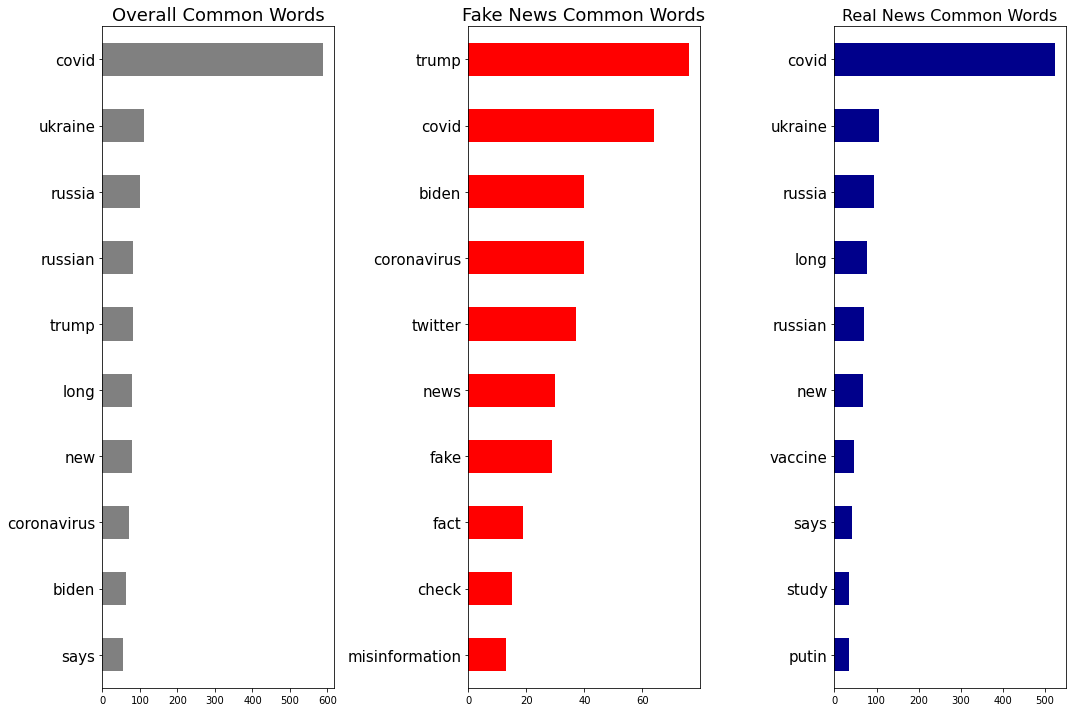

In [29]:
# CountVectorizer
compare_words(news_token_cv, 'class_news', 10)

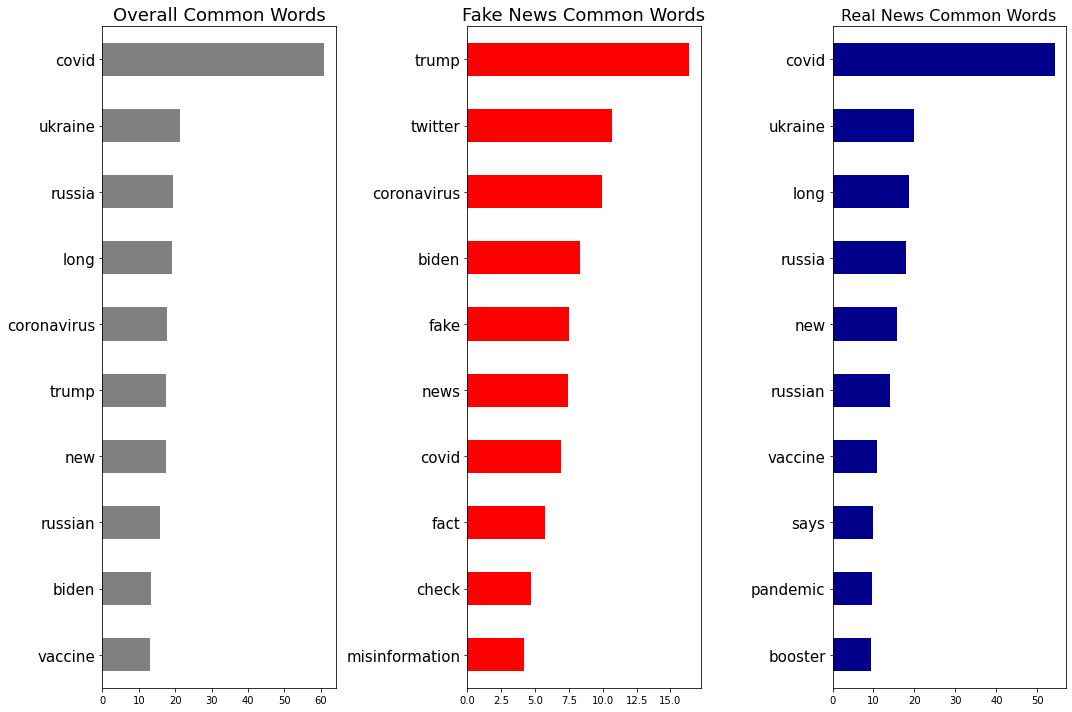

In [30]:
# TFIDF
compare_words(news_token_tfidf, 'class_news', 10)

From both CountVectrizer and TFDF, Covid is the most common words for all news.
For fake news political topic is more popular while real news is Russia and Ukraine war topic.

However, in fake news, there are some cheat keywords that will make models easy to clssify fake news, such as fake and misinformation.


### 4.2.2 Lemmatizing

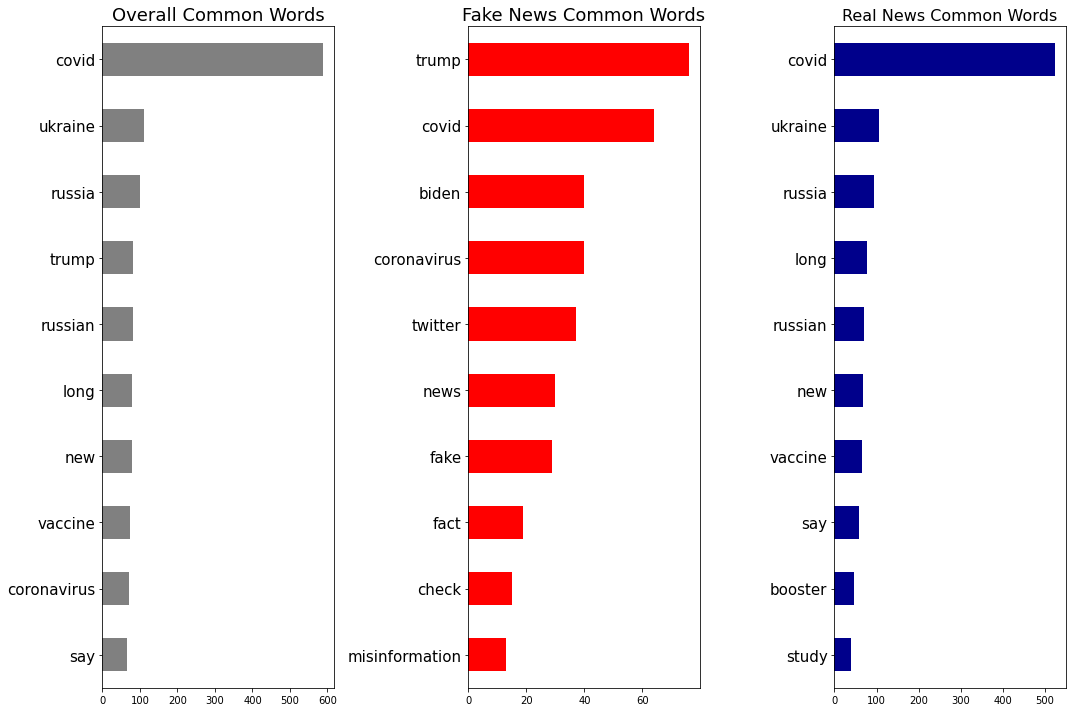

In [31]:
# Lemmatize word
news_lem = shorten_words(news, 'title', 'lem')

# Compare lemmatize common words
compare_words(news_lem, 'class_news', 10, token=False, stop_words='english', n_grame=(1,1))

### 4.2.3 Stemming

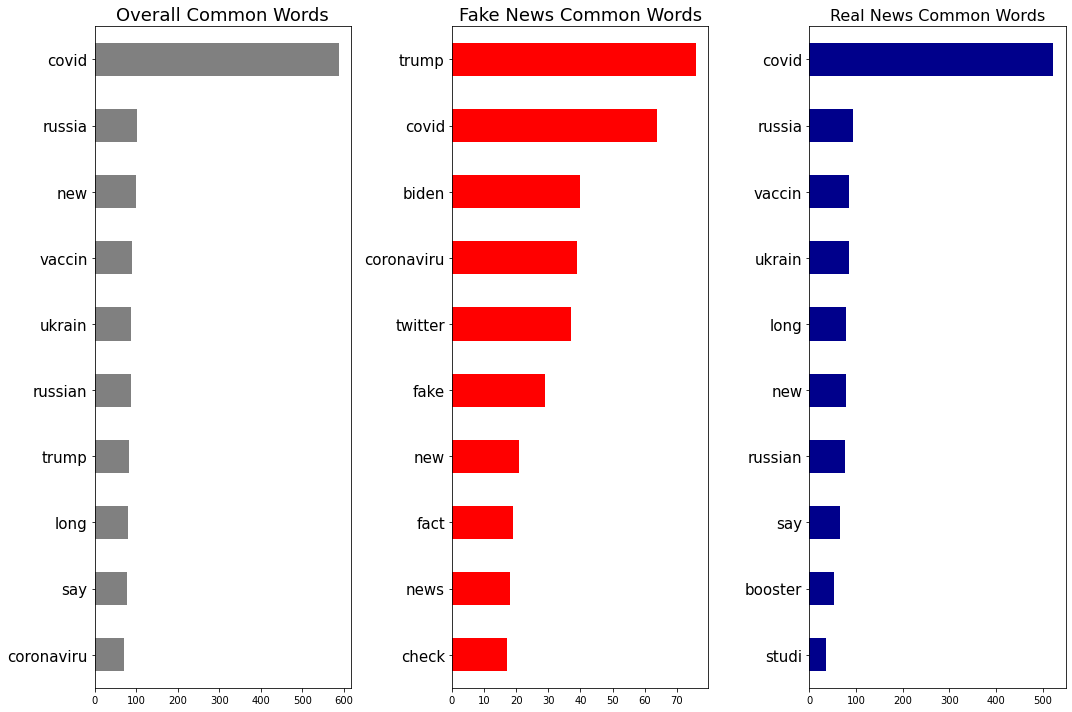

In [32]:
# Stemming word
news_stem = shorten_words(news, 'title', 'stem')

# Compare stemmed common words
compare_words(news_stem, 'class_news', 10, token=False, stop_words='english', n_grame=(1,1))

From both words lemmatizing and stemming also give similar common words as normal CountVectorizer.

## 4.4 Other Characteristics

The other characteristics will contain:
1. Sentiment Analysis
2. Status length
3. Word count
4. Capital count
5. Exclamation count
6. Questionmark count
7. Punctuation count
8. Stop words count
9. Symbol count
10. HTTP count
11. Time stamp count
12. Part of speech count

In [33]:
# Sentiment analysis
sent = SentimentIntensityAnalyzer()

# Copy main dataframe
news_other = news.copy()

# Create polarity scores columns
news_other['sentiment'] = news_other['title'].apply(lambda x: sent.polarity_scores(x)['compound'])

In [34]:
# Status length
news_other['Length'] = news_other['title'].apply(lambda x: len(x))

In [35]:
# Word count
news_other['word count'] = news_other['title'].apply(lambda x: len(x.split()))

In [36]:
# Capital Count
news_other['Capital Count'] = news_other['title'].apply(lambda x: sum(1 for c in x if c.isupper()))

In [37]:
# Exclamation count
news_other['num_exclamation_marks'] = news_other['title'].apply(lambda x: x.count('!'))

In [38]:
# Questionmark count
news_other['num_question_marks'] = news_other['title'].apply(lambda x: x.count('?'))

In [39]:
# Punctuation count
news_other['num_punctuation'] = news_other['title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [40]:
# Stop words count
news_other['num_stopwords'] = news_other['title'].apply(lambda x: len([w for w in str(x).lower().split() \
                                                                         if w in stopwords.words('english')]))


In [41]:
# Symbol count
news_other['num_symbols'] = news_other['title'].apply(lambda x: sum(x.count(w) for w in '*&$%'))

In [42]:
# HTTP count
news_other['has_http'] = news_other['title'].apply(lambda x: count_regexp_occ(r'http[s]{0,1}://\S+', x))

In [43]:
# Time stamp count
news_other['has_timestamp'] = news_other['title'].apply(lambda x: count_regexp_occ(r'\d{2}|:\d{2}', x))

In [44]:
# Part of speech count
for news_other in ([news_other]):
    news_other['nouns'], news_other['adjectives'], news_other['verbs'] = zip(*news_other['title'].apply(
        lambda comment: tag_part_of_speech(comment)))
    news_other['nouns_per_length'] = news_other['nouns'] / news_other['Length']
    news_other['adjectives_per_length'] = news_other['adjectives'] / news_other['Length']
    news_other['verbs_per_length'] = news_other['verbs'] /news_other['Length']
    news_other['nouns_per_words'] = news_other['nouns'] / news_other['word count']
    news_other['adjectives_per_words'] = news_other['adjectives'] / news_other['word count']
    news_other['verbs_per_words'] = news_other['verbs'] / news_other['word count']

In [45]:
# List of analyses
list_eda = ['sentiment','Length','word count','Capital Count','num_exclamation_marks','num_question_marks'
            ,'num_punctuation','num_stopwords','num_symbols','has_http','nouns_per_length','adjectives_per_length'
            ,'verbs_per_length','nouns_per_words','adjectives_per_words','verbs_per_words']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


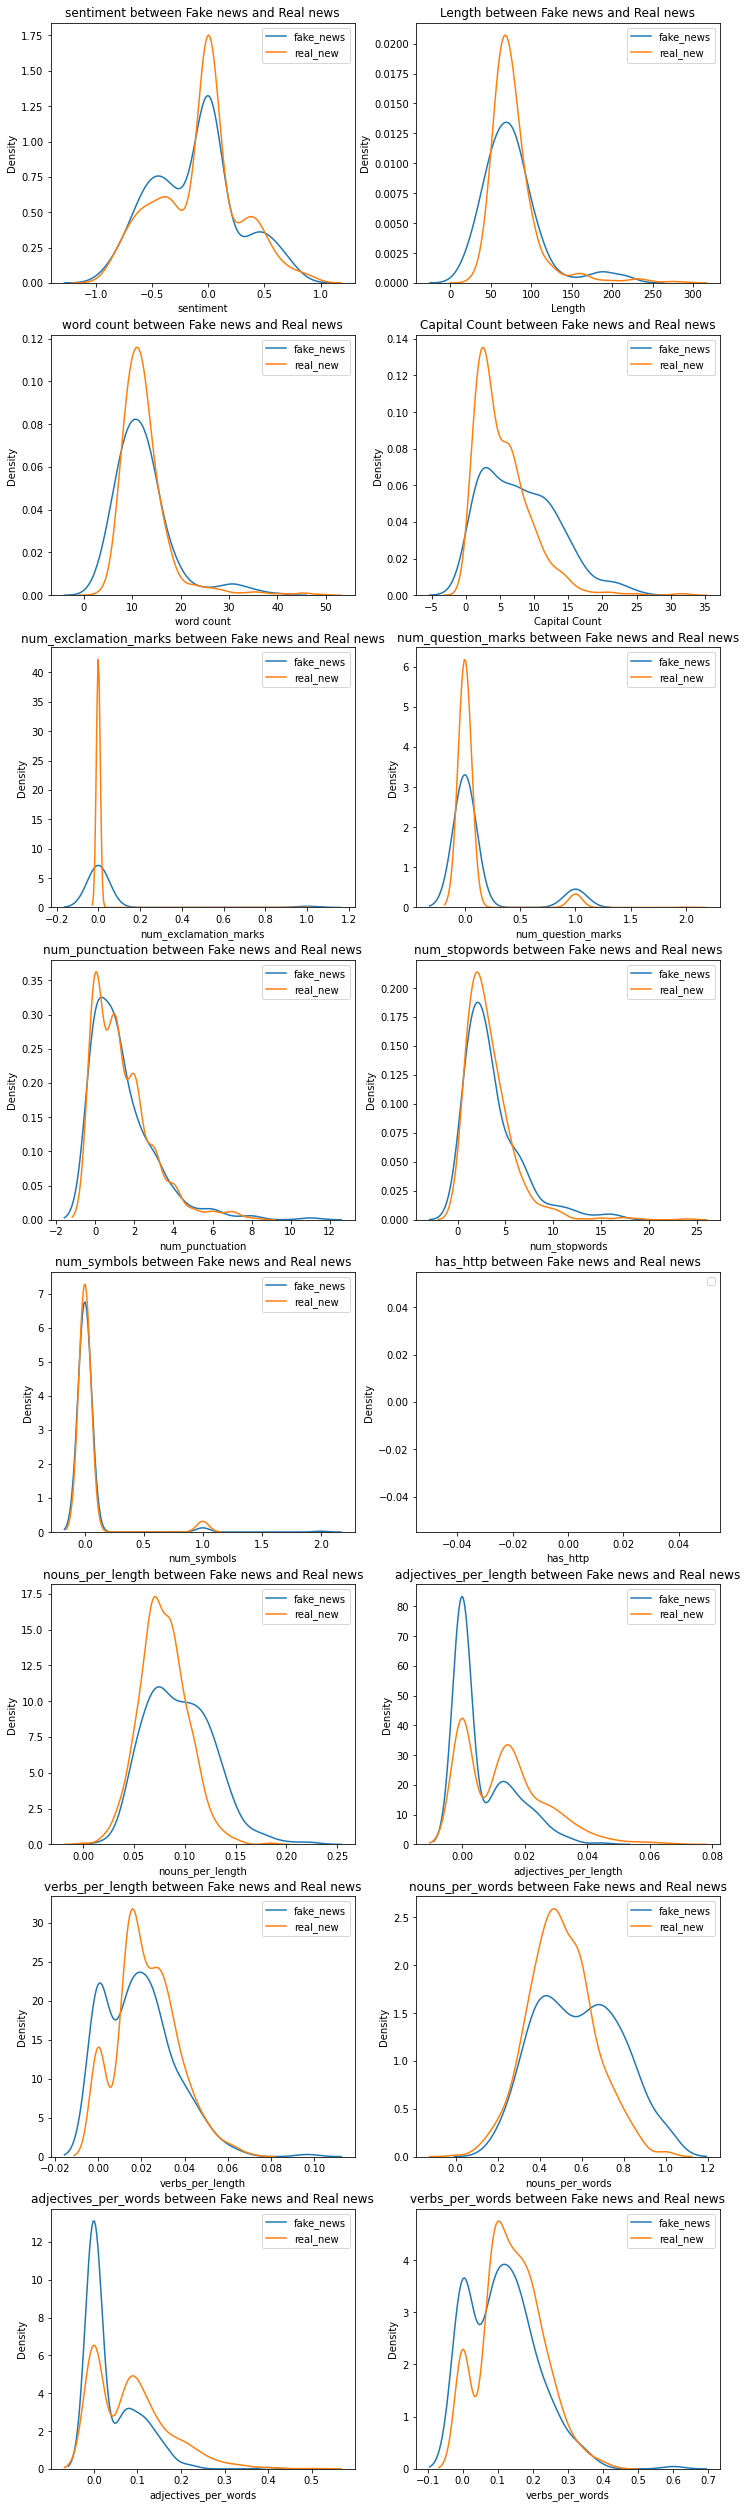

In [46]:
# Plot all analysis in list_eda

warnings.filterwarnings('ignore')

plt.figure(figsize=(12,45))
for i in range(len(list_eda)):
    ax = plt.subplot(int(len(list_eda)/2),2,i+1)
    sns.kdeplot(x=list_eda[i],data=news_other[news_other['class_news']=='fake_news'],label='fake_news',ax=ax)
    sns.kdeplot(x=list_eda[i],data=news_other[news_other['class_news']=='real_news'],label='real_new',ax=ax)
    ax.set_title(f"{list_eda[i]} between Fake news and Real news")
    ax.legend()
    
warnings.resetwarnings()

# 5. Modeling
---

## 5.1 Data Preparation

In [47]:
# Create hyperparameters for all gridsearch models
pipe_params = {
    'vec__max_features' : [100,500,1000]
    ,'vec__ngram_range' : [(1,1),(1,2)]
    ,'vec__min_df': [1, 2]
    ,'vec__max_df': [.8, .9, 1.]
}

In [48]:
# Assign X, y
X = news['title']
y = (news['class_news'] == 'fake_news').astype(int)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [49]:
# Check split shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((805,), (269,), (805,), (269,))

In [50]:
# Chheck value balance
print(y.shape)
y.value_counts(normalize=True).mul(100).round(2)

(1074,)


0    73.93
1    26.07
Name: class_news, dtype: float64

## 5.2 Cheat Keywords Removal

From EDA, we found that there are some cheat keywords that would make our model overfit.
So, this part of analysis will be to remove cheat words from our data

Logistic Regression will be a useful tool to understand cheat keywords from the model coefficient.

We could group our keywords removal to 4 groups
1. Keywords from data selection process
2. Proper noun keywords
3. Cheat keywords
4. Imbalance keywords

### 5.2.1 Logistic Regression + CountVectorizer

#### Remove 0: Remove only stopwords

**Note:** In the model coefficient, we found that a lot of cheat keywords are in dataset, so that make the model's performance too high.

In [51]:
# Get english stop words dict
manual_stopwords = list(CountVectorizer(stop_words='english').get_stop_words())

In [52]:
# Logistic regression pipeline
pipe = Pipeline([
    ('vec', CountVectorizer(max_features=1000, 
                            ngram_range=(1,1),
                            stop_words=manual_stopwords
                           )
    ),
    ('model', LogisticRegression(random_state=42))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(max_features=1000,
                                 stop_words=['whither', 'please', 'thence',
                                             'anyone', 'whatever', 'whoever',
                                             'only', 'of', 'first', 'back',
                                             'somehow', 'since', 'himself',
                                             'become', 'amongst', 'more', 'on',
                                             'less', 'though', 'else', 'always',
                                             'namely', 'during', 'see', 'hasnt',
                                             'none', 'your', 'whereafter',
                                             'anyway', 'either', ...])),
                ('model', LogisticRegression(random_state=42))])

Train score: 0.96
Test score: 0.9


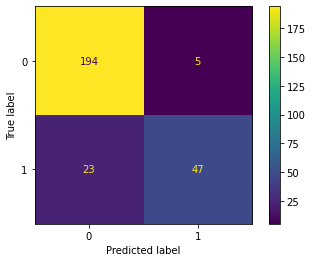

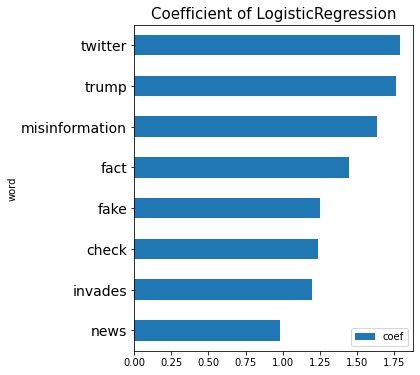


------------------------------ Train Score ------------------------------

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       595
           1       0.98      0.88      0.92       210

    accuracy                           0.96       805
   macro avg       0.97      0.93      0.95       805
weighted avg       0.96      0.96      0.96       805




------------------------------ Test Score ------------------------------

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       199
           1       0.90      0.67      0.77        70

    accuracy                           0.90       269
   macro avg       0.90      0.82      0.85       269
weighted avg       0.90      0.90      0.89       269





In [53]:
# Print score
print('Train score:', pipe.score(X_train, y_train).round(2))
print('Test score:', pipe.score(X_test, y_test).round(2))

# Confusion matrix plot
plot_confusion(pipe, X_test)

# Coeff. plot
coef_df = pd.DataFrame((zip(pipe.named_steps['vec'].get_feature_names_out()\
,pipe.named_steps['model'].coef_[0])),columns=['word','coef'])\
.sort_values(by='coef',ascending=False)
coef_df = coef_df.set_index('word')
coef_df.head(8).sort_values(by='coef').plot(kind='barh', figsize=(5, 6))
plt.yticks(fontsize=14)
plt.title('Coefficient of LogisticRegression', fontsize=15)
plt.show()

# All scores
print('\n------------------------------ Train Score ------------------------------\n')
print(classification_report(y_train,pipe.predict(X_train)),end="\n\n\n")
print('\n------------------------------ Test Score ------------------------------\n')
print(classification_report(y_test,pipe.predict(X_test)),end="\n\n\n")

In [54]:
# Get incorrectly predicted news
df = incorrect_df(pipe, X_test, X_test, y_test)

# Print false negative
print_false(df)

---------- False Negatives -----------
Prediction: Real news
Actual: Fake news

Does The Pfizer covid Vaccine Cause Bell's Palsy?
-----
Gunshots Fired over Resources in Location amidst covid Panic
-----
covid falsehoods lead Stanford to examine ties to right-wing Hoover Institution
-----
U.N. Mysteriously Disappears After Criticizing Russia
-----
Long Covid Keeping 2 To 4 million Americans Out Of Workforce, Report Says
-----
5G Has Nothing to do with covid
-----
Parents Explain Why They Are Not Vaccinating Their Children Against covid
-----
How 5 corrosive conspiracy theories made our fight against covid even harder
-----
Malaysia : No RM1K fine for sitting side-by-side in car during COVID lockdown
-----
Instagram girl lies, accuses CVS of falsifying covid results.
-----
Confused Russian Soldier Was Told Ukrainians Would Be Happy To Be Summarily Executed In Street
-----
This r/louderWithCrowder Meme. Trump tests more covid patients in 4 weeks than other countries have in 4 monthsโ€
--

#### Remove 1: All keywords from data selection process

**Note:** This process will remove keywords that use to select data at the first time by adding the keywords to stopwords list.

But after removing all keywords from data selection process, a model's coefficient revealed that there are some keywords that easy to classify fake news such as proper noun keywords and cheat keywords

In [55]:
# Get english stop words dict
manual_stopwords = list(CountVectorizer(stop_words='english').get_stop_words())

# Add keywords to manual_stopwords
manual_stopwords.extend(sep_keys)

# Add new remove keywords
add_keys = []

# Add keywords to manual_stopwords
manual_stopwords.extend(add_keys)

In [56]:
# test pipe
pipe = Pipeline([
    ('vec', CountVectorizer(max_features=1000, 
                            ngram_range=(1,1),
                            stop_words=manual_stopwords
                           )
    ),
    ('model', LogisticRegression(random_state=42))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(max_features=1000,
                                 stop_words=['whither', 'please', 'thence',
                                             'anyone', 'whatever', 'whoever',
                                             'only', 'of', 'first', 'back',
                                             'somehow', 'since', 'himself',
                                             'become', 'amongst', 'more', 'on',
                                             'less', 'though', 'else', 'always',
                                             'namely', 'during', 'see', 'hasnt',
                                             'none', 'your', 'whereafter',
                                             'anyway', 'either', ...])),
                ('model', LogisticRegression(random_state=42))])

Train score: 0.96
Test score: 0.81


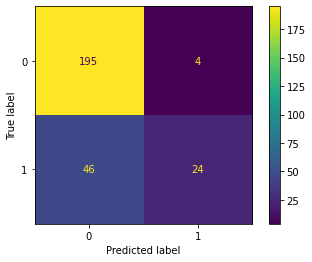

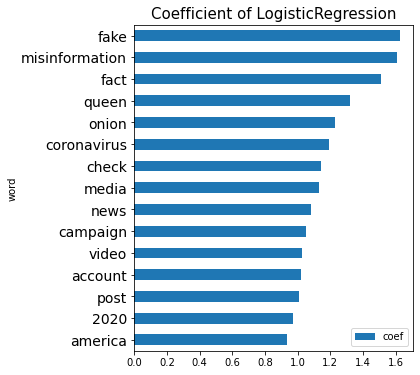


------------------------------ Train Score ------------------------------

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       595
           1       0.99      0.84      0.91       210

    accuracy                           0.96       805
   macro avg       0.97      0.92      0.94       805
weighted avg       0.96      0.96      0.96       805




------------------------------ Test Score ------------------------------

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       199
           1       0.86      0.34      0.49        70

    accuracy                           0.81       269
   macro avg       0.83      0.66      0.69       269
weighted avg       0.82      0.81      0.78       269





In [57]:
# Print score
print('Train score:', pipe.score(X_train, y_train).round(2))
print('Test score:', pipe.score(X_test, y_test).round(2))

# Confusion matrix plot
plot_confusion(pipe, X_test)

# Coeff. plot
coef_df = pd.DataFrame((zip(pipe.named_steps['vec'].get_feature_names_out()\
,pipe.named_steps['model'].coef_[0])),columns=['word','coef'])\
.sort_values(by='coef',ascending=False)
coef_df = coef_df.set_index('word')
coef_df.head(15).sort_values(by='coef').plot(kind='barh', figsize=(5, 6))
plt.yticks(fontsize=14)
plt.title('Coefficient of LogisticRegression', fontsize=15)
plt.show()

# All scores
print('\n------------------------------ Train Score ------------------------------\n')
print(classification_report(y_train,pipe.predict(X_train)),end="\n\n\n")
print('\n------------------------------ Test Score ------------------------------\n')
print(classification_report(y_test,pipe.predict(X_test)),end="\n\n\n")

In [58]:
# Get incorrectly predicted news
df = incorrect_df(pipe, X_test, X_test, y_test)

In [59]:
# Print false negative
print_false(df)

---------- False Negatives -----------
Prediction: Real news
Actual: Fake news

Kamala Harris Quietly Steps Into Frame Behind Biden During Student Debt Cancellation Announcement
-----
Malaysia : No RM1K fine for sitting side-by-side in car during COVID lockdown
-----
How 5 corrosive conspiracy theories made our fight against covid even harder
-----
The swiss national bank now includes hand washing instructions on it's bank notes to counter the corona-crisis
-----
Parents Explain Why They Are Not Vaccinating Their Children Against covid
-----
5G Has Nothing to do with covid
-----
Long Covid Keeping 2 To 4 million Americans Out Of Workforce, Report Says
-----
Trump Boys Thrilled FBI Seized Documents, Leaving Dozens Of Empty Boxes To Play In
-----
Most Glaring Times Trump's Children Have Broken The Law
-----
I found one on Twitter!
-----
Biden Meets With Senate Democrats To Discuss Breaking Up Supreme Court Nominee And Confirming Her In Parts
-----
U.N. Mysteriously Disappears After Criti

#### Remove 2: Proper noun keywords

**Note:** From removing proper noun keywords, cheat keywords showed up obviously in a model's coefficient.

In [60]:
# Get english stop words dict
manual_stopwords = list(CountVectorizer(stop_words='english').get_stop_words())

# Add keywords to manual_stopwords
manual_stopwords.extend(sep_keys)

# Add new remove keywords
add_keys = ['russian', 'ukrainian','tasuku', 'honjo', 'elon', 
 'musk', 'edwerd', 'snowden', 'donald', 'zaporizhzhia',
 'white', 'house','kamala' , 'harris', 'rachel', 'maddow', 
 'crimea', 'queen', 'coronavirus']

# Add keywords to manual_stopwords
manual_stopwords.extend(add_keys)

In [61]:
# test pipe
pipe = Pipeline([
    ('vec', CountVectorizer(max_features=1000, 
                            ngram_range=(1,1),
                            stop_words=manual_stopwords
                           )
    ),
    ('model', LogisticRegression(random_state=42))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(max_features=1000,
                                 stop_words=['whither', 'please', 'thence',
                                             'anyone', 'whatever', 'whoever',
                                             'only', 'of', 'first', 'back',
                                             'somehow', 'since', 'himself',
                                             'become', 'amongst', 'more', 'on',
                                             'less', 'though', 'else', 'always',
                                             'namely', 'during', 'see', 'hasnt',
                                             'none', 'your', 'whereafter',
                                             'anyway', 'either', ...])),
                ('model', LogisticRegression(random_state=42))])

Train score: 0.95
Test score: 0.82


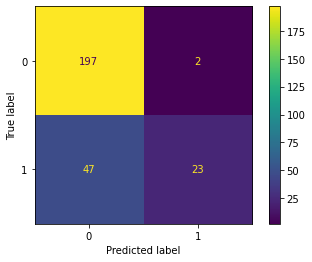

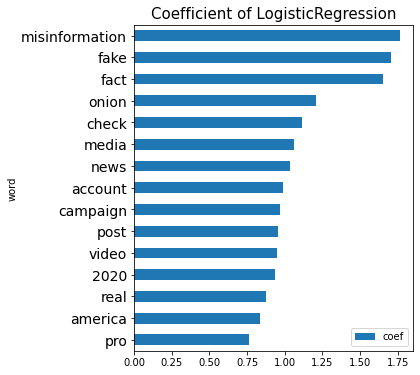


------------------------------ Train Score ------------------------------

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       595
           1       1.00      0.81      0.90       210

    accuracy                           0.95       805
   macro avg       0.97      0.91      0.93       805
weighted avg       0.95      0.95      0.95       805




------------------------------ Test Score ------------------------------

              precision    recall  f1-score   support

           0       0.81      0.99      0.89       199
           1       0.92      0.33      0.48        70

    accuracy                           0.82       269
   macro avg       0.86      0.66      0.69       269
weighted avg       0.84      0.82      0.78       269





In [62]:
# Print score
print('Train score:', pipe.score(X_train, y_train).round(2))
print('Test score:', pipe.score(X_test, y_test).round(2))

# Confusion matrix plot
plot_confusion(pipe, X_test)

# Coeff. plot
coef_df = pd.DataFrame((zip(pipe.named_steps['vec'].get_feature_names_out()\
,pipe.named_steps['model'].coef_[0])),columns=['word','coef'])\
.sort_values(by='coef',ascending=False)
coef_df = coef_df.set_index('word')
coef_df.head(15).sort_values(by='coef').plot(kind='barh', figsize=(5, 6))
plt.yticks(fontsize=14)
plt.title('Coefficient of LogisticRegression', fontsize=15)
plt.show()

# All scores
print('\n------------------------------ Train Score ------------------------------\n')
print(classification_report(y_train,pipe.predict(X_train)),end="\n\n\n")
print('\n------------------------------ Test Score ------------------------------\n')
print(classification_report(y_test,pipe.predict(X_test)),end="\n\n\n")

#### Remove 3: Cheat keywords

**Note:** Coefficient of the model after removing cheat keywords is more neutral but we still can improve our model by removing keywords that are imbalance in real and fake news. 

In [63]:
# Get english stop words dict
manual_stopwords = list(CountVectorizer(stop_words='english').get_stop_words())

# Add keywords to manual_stopwords
manual_stopwords.extend(sep_keys)

# Add new remove keywords
add_keys = ['russian', 'ukrainian','tasuku', 'honjo', 'elon', 
 'musk', 'edwerd', 'snowden', 'donald', 'zaporizhzhia',
 'white', 'house','kamala' , 'harris', 'rachel', 'maddow', 
 'crimea', 'queen', 'coronavirus',
 'parody', 'misinformation', 'fact', 'check', 'real', 
 'falsehoods', 'falsifying', 'conspiracy', 
  'disinformation', 'satire', 'fake', 'onion']

# Add keywords to manual_stopwords
manual_stopwords.extend(add_keys)

In [64]:
# test pipe
pipe = Pipeline([
    ('vec', CountVectorizer(max_features=1000, 
                            ngram_range=(1,1),
                            stop_words=manual_stopwords
                           )
    ),
    ('model', LogisticRegression(random_state=42))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(max_features=1000,
                                 stop_words=['whither', 'please', 'thence',
                                             'anyone', 'whatever', 'whoever',
                                             'only', 'of', 'first', 'back',
                                             'somehow', 'since', 'himself',
                                             'become', 'amongst', 'more', 'on',
                                             'less', 'though', 'else', 'always',
                                             'namely', 'during', 'see', 'hasnt',
                                             'none', 'your', 'whereafter',
                                             'anyway', 'either', ...])),
                ('model', LogisticRegression(random_state=42))])

Train score: 0.95
Test score: 0.81


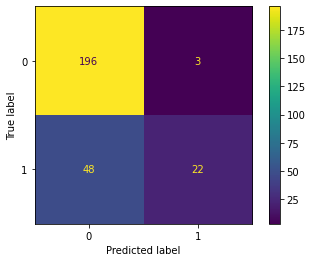

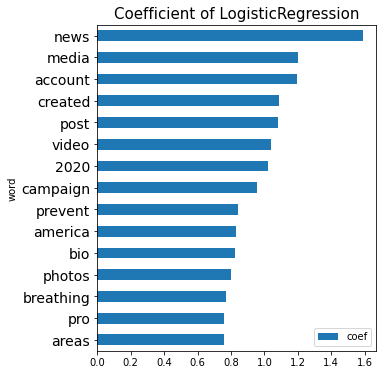


------------------------------ Train Score ------------------------------

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       595
           1       0.99      0.80      0.89       210

    accuracy                           0.95       805
   macro avg       0.96      0.90      0.93       805
weighted avg       0.95      0.95      0.95       805




------------------------------ Test Score ------------------------------

              precision    recall  f1-score   support

           0       0.80      0.98      0.88       199
           1       0.88      0.31      0.46        70

    accuracy                           0.81       269
   macro avg       0.84      0.65      0.67       269
weighted avg       0.82      0.81      0.78       269





In [65]:
# Print score
print('Train score:', pipe.score(X_train, y_train).round(2))
print('Test score:', pipe.score(X_test, y_test).round(2))

# Confusion matrix plot
plot_confusion(pipe, X_test)

# Coeff. plot
coef_df = pd.DataFrame((zip(pipe.named_steps['vec'].get_feature_names_out()\
,pipe.named_steps['model'].coef_[0])),columns=['word','coef'])\
.sort_values(by='coef',ascending=False)
coef_df = coef_df.set_index('word')
coef_df.head(15).sort_values(by='coef').plot(kind='barh', figsize=(5, 6))
plt.yticks(fontsize=14)
plt.title('Coefficient of LogisticRegression', fontsize=15)
plt.show()

# All scores
print('\n------------------------------ Train Score ------------------------------\n')
print(classification_report(y_train,pipe.predict(X_train)),end="\n\n\n")
print('\n------------------------------ Test Score ------------------------------\n')
print(classification_report(y_test,pipe.predict(X_test)),end="\n\n\n")

In [66]:
# Check keywords 'misinformation'
print_news(news, '[Mm]isinformation')

----------------
fake_news:
Where can I post probable covid misinformation to get peoples take on it
----------------
fake_news:
Marcel Schliebs talks about the influence of foreign actors in the 2016 and 2020 US presidential elections and the general spread of misinformation in the age of computational propaganda.
----------------
fake_news:
Majority of Covid misinformation came from 12 people, report finds
----------------
fake_news:
โ€Misinformation isnโ€t going to go away on its ownโ€: Fake News in the era of Trump and Covid
----------------
fake_news:
Twitter says it will start removing covid vaccine misinformation
----------------
fake_news:
Sad Covid story, but author resorts to misinformation and propaganda
----------------
fake_news:
Study Finds โ€Single Largest Driverโ€ of Coronavirus Misinformation: Trump
----------------
fake_news:
Coronavirus Doctors Battle Another Scourge: Misinformation
----------------
fake_news:
Mainstream Media caught again spreading misinformati

Train Accuracy : 0.9478260869565217
Test Accuracy : 0.8104089219330854

Train Classification Report

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       595
           1       0.99      0.80      0.89       210

    accuracy                           0.95       805
   macro avg       0.96      0.90      0.93       805
weighted avg       0.95      0.95      0.95       805



Test Classification Report

              precision    recall  f1-score   support

           0       0.80      0.98      0.88       199
           1       0.88      0.31      0.46        70

    accuracy                           0.81       269
   macro avg       0.84      0.65      0.67       269
weighted avg       0.82      0.81      0.78       269




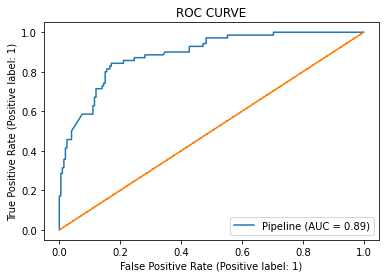

In [67]:
metrics(pipe)

#### Remove 4: Imbalance keywords

In [68]:
# Get english stop words dict
manual_stopwords = list(CountVectorizer(stop_words='english').get_stop_words())

# Add keywords to manual_stopwords
manual_stopwords.extend(sep_keys)

# Add new remove keywords
add_keys = ['russian', 'ukrainian','tasuku', 'honjo', 'elon', 
 'musk', 'edwerd', 'snowden', 'donald', 'zaporizhzhia',
 'white', 'house','kamala' , 'harris', 'rachel', 'maddow', 
 'crimea', 'queen', 'coronavirus',
 'parody', 'misinformation', 'fact', 'check', 'real', 
 'falsehoods', 'falsifying', 'conspiracy',
 'disinformation', 'satire', 'fake', 'onion',
 'post','account', 'presidency', 'vaccine', 'news']

# Add year keywords
add_keys.extend([str(i) for i in range(1990, 2022)])

# Add keywords to manual_stopwords
manual_stopwords.extend(add_keys)

In [69]:
# test pipe
pipe = Pipeline([
    ('vec', CountVectorizer(max_features=1000, 
                            ngram_range=(1,1),
                            stop_words=manual_stopwords
                           )
    ),
    ('model', LogisticRegression(random_state=42))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(max_features=1000,
                                 stop_words=['whither', 'please', 'thence',
                                             'anyone', 'whatever', 'whoever',
                                             'only', 'of', 'first', 'back',
                                             'somehow', 'since', 'himself',
                                             'become', 'amongst', 'more', 'on',
                                             'less', 'though', 'else', 'always',
                                             'namely', 'during', 'see', 'hasnt',
                                             'none', 'your', 'whereafter',
                                             'anyway', 'either', ...])),
                ('model', LogisticRegression(random_state=42))])

Train score: 0.95
Test score: 0.8


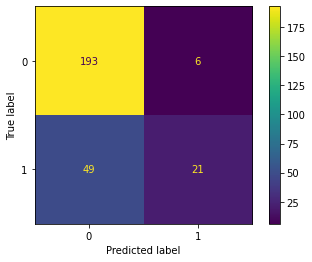

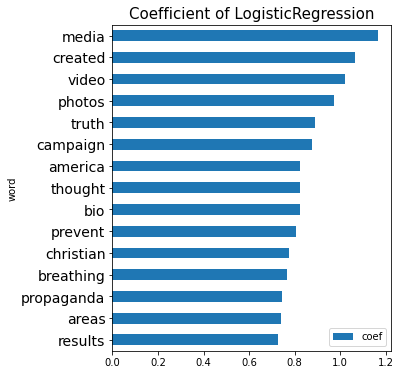


------------------------------ Train Score ------------------------------

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       595
           1       0.99      0.81      0.89       210

    accuracy                           0.95       805
   macro avg       0.97      0.90      0.93       805
weighted avg       0.95      0.95      0.95       805




------------------------------ Test Score ------------------------------

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       199
           1       0.78      0.30      0.43        70

    accuracy                           0.80       269
   macro avg       0.79      0.63      0.65       269
weighted avg       0.79      0.80      0.76       269





In [70]:
# Print score
print('Train score:', pipe.score(X_train, y_train).round(2))
print('Test score:', pipe.score(X_test, y_test).round(2))

# Confusion matrix plot
plot_confusion(pipe, X_test)

# Coeff. plot
coef_df = pd.DataFrame((zip(pipe.named_steps['vec'].get_feature_names_out()\
,pipe.named_steps['model'].coef_[0])),columns=['word','coef'])\
.sort_values(by='coef',ascending=False)
coef_df = coef_df.set_index('word')
coef_df.head(15).sort_values(by='coef').plot(kind='barh', figsize=(5, 6))
plt.yticks(fontsize=14)
plt.title('Coefficient of LogisticRegression', fontsize=15)
plt.show()

# All scores
print('\n------------------------------ Train Score ------------------------------\n')
print(classification_report(y_train,pipe.predict(X_train)),end="\n\n\n")
print('\n------------------------------ Test Score ------------------------------\n')
print(classification_report(y_test,pipe.predict(X_test)),end="\n\n\n")

In [71]:
sep_keys

['trump',
 'biden',
 'twitter',
 'covid',
 'elizabeth',
 'president',
 'russia',
 'ukraine',
 'corona',
 'putin']

In [72]:
len(['russian', 'ukrainian','tasuku', 'honjo', 'elon', 
 'musk', 'edwerd', 'snowden', 'donald', 'zaporizhzhia',
 'white', 'house','kamala' , 'harris', 'rachel', 'maddow', 
 'crimea', 'queen', 'coronavirus',
 'parody', 'misinformation', 'fact', 'check', 'real', 
 'falsehoods', 'falsifying', 'conspiracy',
 'disinformation', 'satire', 'fake', 'onion',
 'post','account', 'presidency', 'vaccine', 'news'])

36

In [73]:
len(['coronavirus', 'queen', 'fact', 'check', 'misinformation',
            'russian', 'ukrainian',
           'real', 'post', 'conspiracy', 'tasuku', 'honjo', 'parody', 'disinformation',
           'edwerd', 'snowden','elon', 'musk', 'rachel', 'maddow', 'kamala' , 'harris', 'white', 'house',
           'falsehoods', 'falsifying', 'donald', 'presidency', 'satire', 'crimea', 'zaporizhzhia'
           ,'account', 'vaccine', 'onion', 'fake', 'news'])

36

In [74]:
sep_keys

['trump',
 'biden',
 'twitter',
 'covid',
 'elizabeth',
 'president',
 'russia',
 'ukraine',
 'corona',
 'putin']

#### Remove 5: Re-add stopwords

**Note:** We are trying to more generalized our model by adding stop words back to dataset.

Now the final model can use stop words that we manually selected.

In [75]:
# Add new remove keywords
add_keys = ['russian', 'ukrainian','tasuku', 'honjo', 'elon', 
 'musk', 'edwerd', 'snowden', 'donald', 'zaporizhzhia',
 'white', 'house','kamala' , 'harris', 'rachel', 'maddow', 
 'crimea', 'queen', 'coronavirus',
 'parody', 'misinformation', 'fact', 'check', 'real', 
 'falsehoods', 'falsifying', 'conspiracy',
 'disinformation', 'satire', 'fake', 'onion',
 'post','account', 'presidency', 'vaccine', 'news']

# Add year keywords
add_keys.extend([str(i) for i in range(1990, 2022)])

# Combine additional and year keywords
manual_stopwords = set(add_keys + sep_keys)

In [76]:
# test pipe
pipe = Pipeline([
    ('vec', CountVectorizer(max_features=1000, 
                            ngram_range=(1,1),
                            stop_words=manual_stopwords
                           )
    ),
    ('model', LogisticRegression(random_state=42))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(max_features=1000,
                                 stop_words={'1990', '1991', '1992', '1993',
                                             '1994', '1995', '1996', '1997',
                                             '1998', '1999', '2000', '2001',
                                             '2002', '2003', '2004', '2005',
                                             '2006', '2007', '2008', '2009',
                                             '2010', '2011', '2012', '2013',
                                             '2014', '2015', '2016', '2017',
                                             '2018', '2019', ...})),
                ('model', LogisticRegression(random_state=42))])

Train score: 0.96
Test score: 0.79


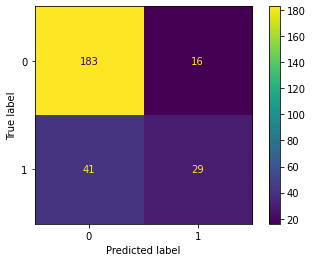

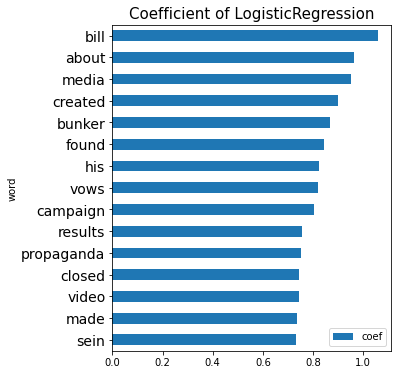


------------------------------ Train Score ------------------------------

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       595
           1       0.97      0.87      0.92       210

    accuracy                           0.96       805
   macro avg       0.96      0.93      0.94       805
weighted avg       0.96      0.96      0.96       805




------------------------------ Test Score ------------------------------

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       199
           1       0.64      0.41      0.50        70

    accuracy                           0.79       269
   macro avg       0.73      0.67      0.68       269
weighted avg       0.77      0.79      0.77       269





In [77]:
# Print score
print('Train score:', pipe.score(X_train, y_train).round(2))
print('Test score:', pipe.score(X_test, y_test).round(2))

# Confusion matrix plot
plot_confusion(pipe, X_test)

# Coeff. plot
coef_df = pd.DataFrame((zip(pipe.named_steps['vec'].get_feature_names_out()\
,pipe.named_steps['model'].coef_[0])),columns=['word','coef'])\
.sort_values(by='coef',ascending=False)
coef_df = coef_df.set_index('word')
coef_df.head(15).sort_values(by='coef').plot(kind='barh', figsize=(5, 6))
plt.yticks(fontsize=14)
plt.title('Coefficient of LogisticRegression', fontsize=15)
plt.show()

# All scores
print('\n------------------------------ Train Score ------------------------------\n')
print(classification_report(y_train,pipe.predict(X_train)),end="\n\n\n")
print('\n------------------------------ Test Score ------------------------------\n')
print(classification_report(y_test,pipe.predict(X_test)),end="\n\n\n")

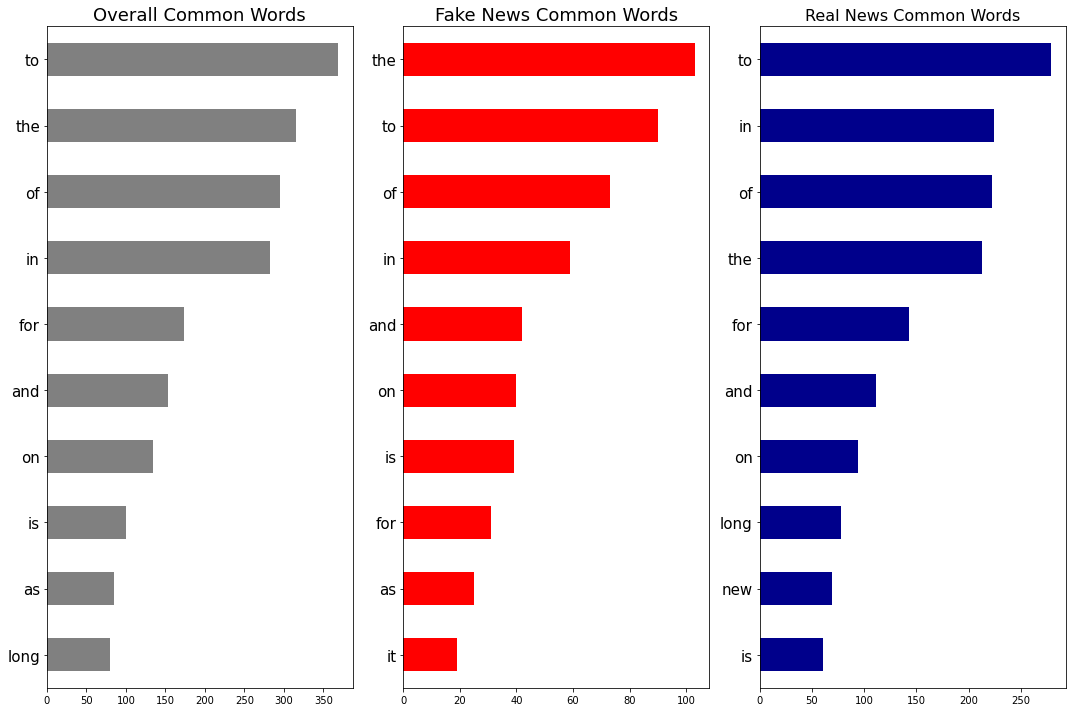

In [78]:
# CountVectorizer
compare_words(news, 'class_news', 10, token=False, stop_words=manual_stopwords)

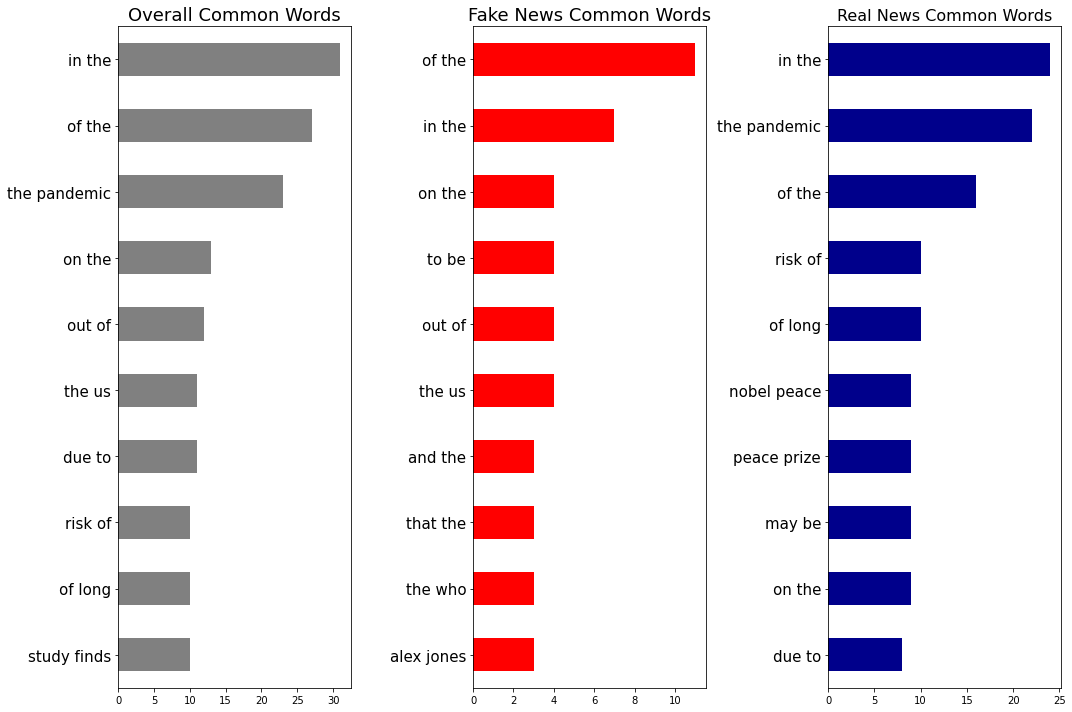

In [79]:
# Bigram
compare_words(news, 'class_news', 10, token=False, stop_words=manual_stopwords, n_grame=(2,2))

C:\Users\Chalermchon Wongsopa\AppData\Local\Temp\ipykernel_14224\1930500304.py:43: UserWarning: Glyph 3650 (\N{THAI CHARACTER SARA O}) missing from current font.
  plt.tight_layout()
D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 3650 (\N{THAI CHARACTER SARA O}) missing from current font.
  func(*args, **kwargs)
D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 3650 (\N{THAI CHARACTER SARA O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


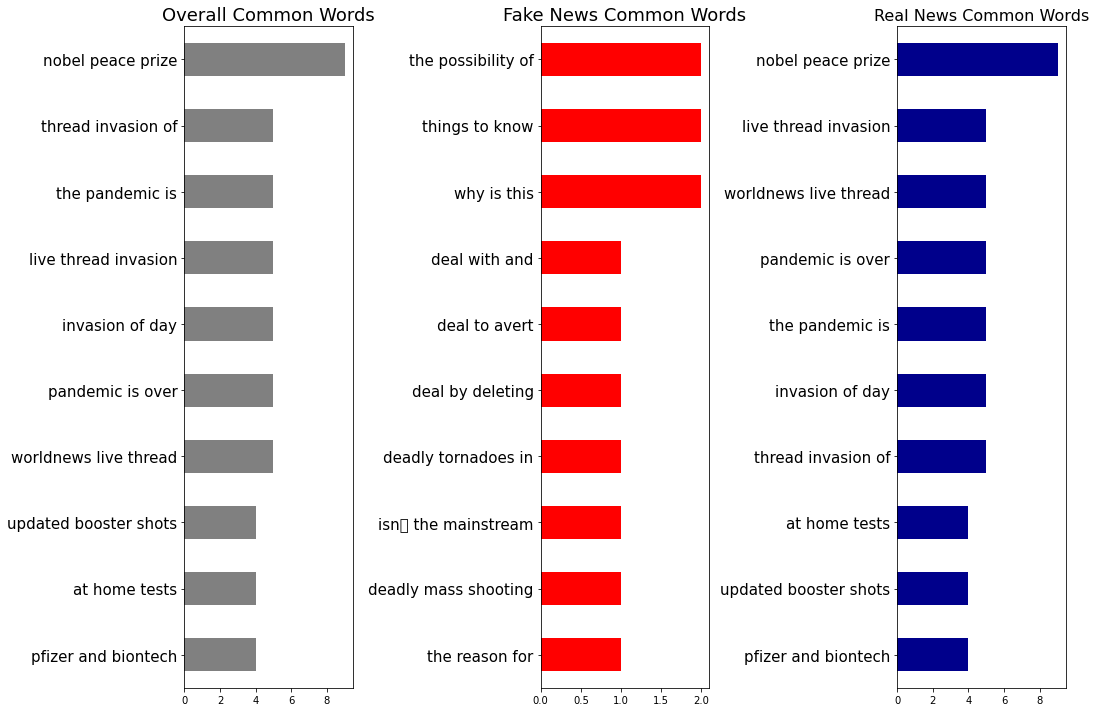

In [80]:
# Trigram
compare_words(news, 'class_news', 10, token=False, stop_words=manual_stopwords, n_grame=(3,3))

### 5.3 Logistic regression + CountVectorizer

Best Hyperparameter : {'vec__max_df': 0.8, 'vec__max_features': 1000, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}
Train Accuracy : 0.9552795031055901
Test Accuracy : 0.7695167286245354

Train Classification Report

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       595
           1       0.97      0.85      0.91       210

    accuracy                           0.96       805
   macro avg       0.96      0.92      0.94       805
weighted avg       0.96      0.96      0.95       805



Test Classification Report

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       199
           1       0.58      0.40      0.47        70

    accuracy                           0.77       269
   macro avg       0.70      0.65      0.66       269
weighted avg       0.75      0.77      0.75       269




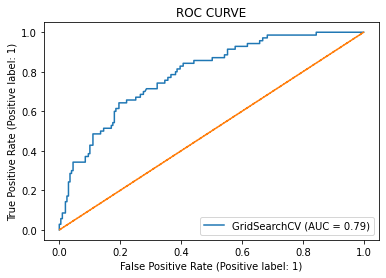

In [81]:
# Logistic regression + CountVectorizer
pipe_logreg_cv = Pipeline([
    ('vec', CountVectorizer(stop_words=manual_stopwords))
    ,('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

logreg_cv = GridSearchCV(pipe_logreg_cv
                       ,param_grid=pipe_params
                       ,cv=5)

logreg_cv.fit(X_train, y_train)

# Evaluate model.
print(f"Best Hyperparameter : {logreg_cv.best_params_}",end="\n")
metrics(logreg_cv)

### 5.4 Logistic regression + TFIDF

Best Hyperparameter : {'vec__max_df': 0.8, 'vec__max_features': 500, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}
Train Accuracy : 0.8298136645962733
Test Accuracy : 0.7620817843866171

Train Classification Report

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       595
           1       0.95      0.37      0.53       210

    accuracy                           0.83       805
   macro avg       0.88      0.68      0.71       805
weighted avg       0.85      0.83      0.80       805



Test Classification Report

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       199
           1       0.65      0.19      0.29        70

    accuracy                           0.76       269
   macro avg       0.71      0.58      0.57       269
weighted avg       0.74      0.76      0.71       269




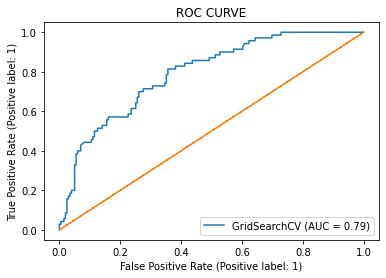

In [82]:
# Logistic regression + TFIDF
pipe_logreg_tfidf = Pipeline([
    ('vec', TfidfVectorizer(stop_words=manual_stopwords))
    ,('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

logreg_tfidf = GridSearchCV(pipe_logreg_tfidf
                       ,param_grid=pipe_params
                       ,cv=5)

logreg_tfidf.fit(X_train, y_train)

# Evaluate model.
print(f"Best Hyperparameter : {logreg_tfidf.best_params_}",end="\n")
metrics(logreg_tfidf)

### 5.5 MultiomialNB + CountVectorizer

Best Hyperparameter : {'vec__max_df': 0.8, 'vec__max_features': 1000, 'vec__min_df': 1, 'vec__ngram_range': (1, 1)}
Train Accuracy : 0.9204968944099379
Test Accuracy : 0.8029739776951673

Train Classification Report

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       595
           1       0.91      0.77      0.84       210

    accuracy                           0.92       805
   macro avg       0.92      0.87      0.89       805
weighted avg       0.92      0.92      0.92       805



Test Classification Report

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       199
           1       0.72      0.40      0.51        70

    accuracy                           0.80       269
   macro avg       0.77      0.67      0.70       269
weighted avg       0.79      0.80      0.78       269




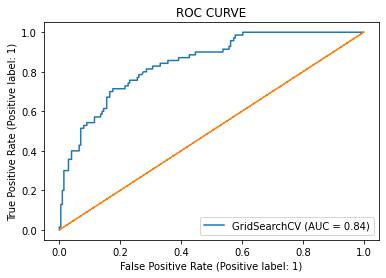

In [83]:
# MultinomialNB + CountVectorizer

pipe_nb_cv = Pipeline([
    ('vec', CountVectorizer(stop_words=manual_stopwords))
    ,('mb', MultinomialNB())
])

nb_cv = GridSearchCV(pipe_nb_cv
                       ,param_grid=pipe_params
                       ,cv=5)

nb_cv.fit(X_train, y_train)

# Evaluate model.
print(f"Best Hyperparameter : {nb_cv.best_params_}",end="\n")
metrics(nb_cv)

### 5.6 MultiomialNB + TFIDF

Best Hyperparameter : {'vec__max_df': 0.8, 'vec__max_features': 500, 'vec__min_df': 1, 'vec__ngram_range': (1, 2)}
Train Accuracy : 0.8360248447204969
Test Accuracy : 0.7769516728624535

Train Classification Report

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       595
           1       0.94      0.40      0.56       210

    accuracy                           0.84       805
   macro avg       0.88      0.69      0.73       805
weighted avg       0.85      0.84      0.81       805



Test Classification Report

              precision    recall  f1-score   support

           0       0.78      0.98      0.87       199
           1       0.78      0.20      0.32        70

    accuracy                           0.78       269
   macro avg       0.78      0.59      0.59       269
weighted avg       0.78      0.78      0.72       269




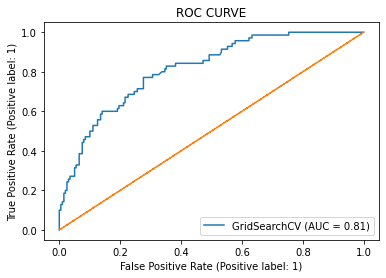

In [84]:
# MultinomialNB + TFIDF

pipe_nb_cv = Pipeline([
    ('vec', TfidfVectorizer(stop_words=manual_stopwords))
    ,('mb', MultinomialNB())
])

nb_tfidf = GridSearchCV(pipe_nb_cv
                       ,param_grid=pipe_params
                       ,cv=5)

nb_tfidf.fit(X_train, y_train)

# Evaluate model.
print(f"Best Hyperparameter : {nb_tfidf.best_params_}",end="\n")
metrics(nb_tfidf)

# 6. Models Evaluation
---

## 6.1 Compare Models

In [85]:
# Baseline score
y.value_counts(normalize=True).mul(100).round(2)

0    73.93
1    26.07
Name: class_news, dtype: float64

In [86]:
# Compare all of gridsearch models' performance
metrics_summary = pd.DataFrame({"Accuracy":[
                            logreg_cv.score(X_train, y_train), logreg_tfidf.score(X_train, y_train),
                            nb_cv.score(X_train, y_train), nb_tfidf.score(X_train, y_train),
                            logreg_cv.score(X_test, y_test), logreg_tfidf.score(X_test, y_test),
                            nb_cv.score(X_test, y_test), nb_tfidf.score(X_test, y_test),
                            ],
                                "Precision_Score": [precision_score(y_train, logreg_cv.predict(X_train))
                                                    ,precision_score(y_train, logreg_tfidf.predict(X_train))
                                                    ,precision_score(y_train, nb_cv.predict(X_train))
                                                    ,precision_score(y_train, nb_tfidf.predict(X_train))
                                                    ,precision_score(y_test, logreg_cv.predict(X_test))
                                                    ,precision_score(y_test, logreg_tfidf.predict(X_test))
                                                    ,precision_score(y_test, nb_cv.predict(X_test))
                                                    ,precision_score(y_test, nb_tfidf.predict(X_test))],
                                "Recall_score": [recall_score(y_train, logreg_cv.predict(X_train))
                                                    ,recall_score(y_train, logreg_tfidf.predict(X_train))
                                                    ,recall_score(y_train, nb_cv.predict(X_train))
                                                    ,recall_score(y_train, nb_tfidf.predict(X_train))
                                                    ,recall_score(y_test, logreg_cv.predict(X_test))
                                                    ,recall_score(y_test, logreg_tfidf.predict(X_test))
                                                    ,recall_score(y_test, nb_cv.predict(X_test))
                                                    ,recall_score(y_test, nb_tfidf.predict(X_test))],
                                "F1_score": [f1_score(y_train, logreg_cv.predict(X_train))
                                                    ,f1_score(y_train, logreg_tfidf.predict(X_train))
                                                    ,f1_score(y_train, nb_cv.predict(X_train))
                                                    ,f1_score(y_train, nb_tfidf.predict(X_train))
                                                    ,f1_score(y_test, logreg_cv.predict(X_test))
                                                    ,f1_score(y_test, logreg_tfidf.predict(X_test))
                                                    ,f1_score(y_test, nb_cv.predict(X_test))
                                                    ,f1_score(y_test, nb_tfidf.predict(X_test))],
                                "Roc_Auc_Score": [roc_auc_score(y_train, logreg_cv.predict(X_train))
                                                    ,roc_auc_score(y_train, logreg_tfidf.predict(X_train))
                                                    ,roc_auc_score(y_train, nb_cv.predict(X_train))
                                                    ,roc_auc_score(y_train, nb_tfidf.predict(X_train))
                                                    ,roc_auc_score(y_test, logreg_cv.predict(X_test))
                                                    ,roc_auc_score(y_test, logreg_tfidf.predict(X_test))
                                                    ,roc_auc_score(y_test, nb_cv.predict(X_test))
                                                    ,roc_auc_score(y_test, nb_tfidf.predict(X_test))]
                               }
                              )

metrics_summary.index = ['train_cvec_logreg','train_tfidf_logreg','train_cvec_mb','train_tfidf_mb', 
                         'test_cvec_logreg','test_tfidf_logreg','test_cvec_mb','test_tfidf_mb']
metrics_summary

,Accuracy,Precision_Score,Recall_score,F1_score,Roc_Auc_Score
train_cvec_logreg,0.955280,0.972826,0.852381,0.908629,0.921989
train_tfidf_logreg,0.829814,0.950617,0.366667,0.529210,0.679972
train_cvec_mb,0.920497,0.910112,0.771429,0.835052,0.872269
train_tfidf_mb,0.836025,0.943182,0.395238,0.557047,0.693417
test_cvec_logreg,0.769517,0.583333,0.400000,0.474576,0.649749
test_tfidf_logreg,0.762082,0.650000,0.185714,0.288889,0.575269
test_cvec_mb,0.802974,0.717949,0.400000,0.513761,0.672362
test_tfidf_mb,0.776952,0.777778,0.200000,0.318182,0.589950


**Note:** As per a result, the opimal model in terms of F1 and precision score is multinomial Naive Bayes with CountVectorizer.

## 6.2 Final Model

### 6.2.1 MultinomialNB + CountVectorizer

**Note:** The model performance can show that testing set's accuracy is 80% but the model is still not good at recall but better in precision at 70%.

Imply that the model is poor in finding all fake news of test set but once the classify a document as fake news there is 70% correctly classify.

In [87]:
# Add new remove keywords
add_keys = ['coronavirus', 'queen', 'fact', 'check', 'misinformation',
           'ukraine', 'russia', 'putin', 'russian', 'ukrainian',
           'real', 'post', 'conspiracy', 'tasuku', 'honjo', 'parody', 'disinformation',
           'edwerd', 'snowden', 'falsehood','elon', 'musk', 'rachel', 'maddow', 'kamala' , 'harris', 'white', 'house',
           'falsehoods', 'falsifying', 'donald', 'presidency', 'satire', 'crimea', 'zaporizhzhia'
           ,'account', 'vaccine', 'onion', 'fake', 'news']

# Add year keywords
add_keys.extend([str(i) for i in range(1990, 2022)])

# Combine additional and year keywords
manual_stopwords = set(add_keys + sep_keys)

In [88]:
# Best Hyperparameter : {'vec__max_df': 0.8, 'vec__max_features': 1000, 
# 'vec__min_df': 1, 'vec__ngram_range': (1, 1)}

# test pipe
pipe = Pipeline([
    ('vec', CountVectorizer(max_features=1000, 
                            ngram_range=(1,1),
                            min_df=1,
                            max_df=0.8,
                            stop_words=manual_stopwords
                           )
    ),
    ('model', MultinomialNB())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(max_df=0.8, max_features=1000,
                                 stop_words={'1990', '1991', '1992', '1993',
                                             '1994', '1995', '1996', '1997',
                                             '1998', '1999', '2000', '2001',
                                             '2002', '2003', '2004', '2005',
                                             '2006', '2007', '2008', '2009',
                                             '2010', '2011', '2012', '2013',
                                             '2014', '2015', '2016', '2017',
                                             '2018', '2019', ...})),
                ('model', MultinomialNB())])

Train score: 0.92
Test score: 0.8

------------------------------ Train Score ------------------------------

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       595
           1       0.91      0.77      0.84       210

    accuracy                           0.92       805
   macro avg       0.92      0.87      0.89       805
weighted avg       0.92      0.92      0.92       805




------------------------------ Test Score ------------------------------

              precision    recall  f1-score   support

           0       0.82      0.94      0.88       199
           1       0.72      0.40      0.51        70

    accuracy                           0.80       269
   macro avg       0.77      0.67      0.70       269
weighted avg       0.79      0.80      0.78       269





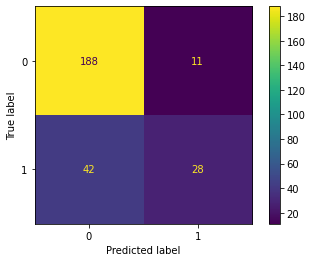

In [89]:
# Print score
print('Train score:', pipe.score(X_train, y_train).round(2))
print('Test score:', pipe.score(X_test, y_test).round(2))

# Confusion matrix plot
plot_confusion(pipe, X_test)

# All scores
print('\n------------------------------ Train Score ------------------------------\n')
print(classification_report(y_train,pipe.predict(X_train)),end="\n\n\n")
print('\n------------------------------ Test Score ------------------------------\n')
print(classification_report(y_test,pipe.predict(X_test)),end="\n\n\n")

### 6.2.2 Logistic regression + CountVectorizer

**Note:** We use Logistic Regression model that tuned as best parameters tunning from MultinomialNB + CountVectorizer above to understand coefficient of the model.

In [90]:
# Add new remove keywords
add_keys = ['coronavirus', 'queen', 'fact', 'check', 'misinformation',
           'ukraine', 'russia', 'putin', 'russian', 'ukrainian',
           'real', 'post', 'conspiracy', 'tasuku', 'honjo', 'parody', 'disinformation',
           'edwerd', 'snowden', 'falsehood','elon', 'musk', 'rachel', 'maddow', 'kamala' , 'harris', 'white', 'house',
           'falsehoods', 'falsifying', 'donald', 'presidency', 'satire', 'crimea', 'zaporizhzhia'
           ,'account', 'vaccine', 'onion', 'fake', 'news']

# Add year keywords
add_keys.extend([str(i) for i in range(1990, 2022)])

# Combine additional and year keywords
manual_stopwords = set(add_keys + sep_keys)

In [91]:
# Best Hyperparameter : {'vec__max_df': 0.8, 'vec__max_features': 1000, 
# 'vec__min_df': 1, 'vec__ngram_range': (1, 1)}

# test pipe
pipe = Pipeline([
    ('vec', CountVectorizer(max_features=1000, 
                            ngram_range=(1,1),
                            min_df=1,
                            max_df=0.8,
                            stop_words=manual_stopwords
                           )
    ),
    ('model', LogisticRegression(random_state=42))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vec',
                 CountVectorizer(max_df=0.8, max_features=1000,
                                 stop_words={'1990', '1991', '1992', '1993',
                                             '1994', '1995', '1996', '1997',
                                             '1998', '1999', '2000', '2001',
                                             '2002', '2003', '2004', '2005',
                                             '2006', '2007', '2008', '2009',
                                             '2010', '2011', '2012', '2013',
                                             '2014', '2015', '2016', '2017',
                                             '2018', '2019', ...})),
                ('model', LogisticRegression(random_state=42))])

Train score: 0.96
Test score: 0.79


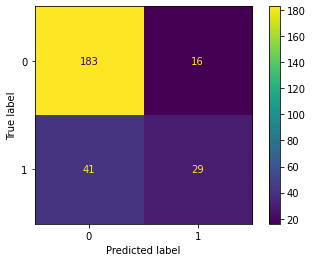

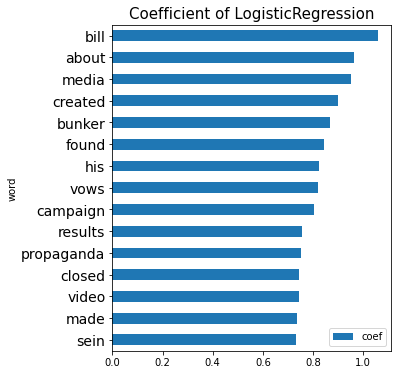


------------------------------ Train Score ------------------------------

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       595
           1       0.97      0.87      0.92       210

    accuracy                           0.96       805
   macro avg       0.96      0.93      0.94       805
weighted avg       0.96      0.96      0.96       805




------------------------------ Test Score ------------------------------

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       199
           1       0.64      0.41      0.50        70

    accuracy                           0.79       269
   macro avg       0.73      0.67      0.68       269
weighted avg       0.77      0.79      0.77       269





In [92]:
# Print score
print('Train score:', pipe.score(X_train, y_train).round(2))
print('Test score:', pipe.score(X_test, y_test).round(2))

# Confusion matrix plot
plot_confusion(pipe, X_test)

# Coeff. plot
coef_df = pd.DataFrame((zip(pipe.named_steps['vec'].get_feature_names_out()\
,pipe.named_steps['model'].coef_[0])),columns=['word','coef'])\
.sort_values(by='coef',ascending=False)
coef_df = coef_df.set_index('word')
coef_df.head(15).sort_values(by='coef').plot(kind='barh', figsize=(5, 6))
plt.yticks(fontsize=14)
plt.title('Coefficient of LogisticRegression', fontsize=15)
plt.show()

# All scores
print('\n------------------------------ Train Score ------------------------------\n')
print(classification_report(y_train,pipe.predict(X_train)),end="\n\n\n")
print('\n------------------------------ Test Score ------------------------------\n')
print(classification_report(y_test,pipe.predict(X_test)),end="\n\n\n")

# 7. Real Case Adaptaion
---

## 7.1 Prediction testing
This section is to predict real news from other sources to test the model.

### 7.1.1 Correctly prediction

In [93]:
# Real news
test_news(nb_cv, 'Biden sends a careful but chilling new nuclear message to Putin in CNN interview')

# https://edition.cnn.com/2022/10/12/politics/joe-biden-nuclear-message-putin-cnntv-analysis/index.html

Predicting...
Input: Biden sends a careful but chilling new nuclear message to Putin in CNN interview
Prediction: Real news


In [94]:
# Fake news
test_news(nb_cv, 'A video of Ukrainian President Volodymyr Zelensky in a conference call shows cocaine on his desk.')

Predicting...
Input: A video of Ukrainian President Volodymyr Zelensky in a conference call shows cocaine on his desk.
Prediction: Fake news


In [95]:
# Fake news
test_news(nb_cv, "Hey Facebook, As some of you may know, I'm Bill Gates. If you click that share link, I will give you $5,000. I always deliver, I mean, I brought you Windows XP, right?")

Predicting...
Input: Hey Facebook, As some of you may know, I'm Bill Gates. If you click that share link, I will give you $5,000. I always deliver, I mean, I brought you Windows XP, right?
Prediction: Fake news


**Note:** The model is able to predict news from external website such as CNN to be real new. And also able to detect fake news from non-subreddit sources.

### 7.2.2 Incorrectly prediction

In [96]:
# Fake news
test_news(nb_cv, "Nigeria Feeding Human Corpses to Zoo Animals")
# http://cityworldnews.com/nigeria-human-corpses-zoo/

Predicting...
Input: Nigeria Feeding Human Corpses to Zoo Animals
Prediction: Real news


In [97]:
# Fake news
test_news(nb_cv, "Jurassic Marijuana Plant Brought Back To Life After 200 Million Years")
# http://cityworldnews.com/jurassic-marijuana-plant/

Predicting...
Input: Jurassic Marijuana Plant Brought Back To Life After 200 Million Years
Prediction: Real news


In [98]:
# Fake news
test_news(nb_cv, "Hillary Clinton And ISIS Are Funded By The Same Money.")
# http://cityworldnews.com/assange-truth-bomb-hillary-clinton-and-isis-are-funded-by-the-same-money/

Predicting...
Input: Hillary Clinton And ISIS Are Funded By The Same Money.
Prediction: Real news


In [99]:
# Fake news
test_news(nb_cv, 'BirdJR and Gun are President and Vice President of United State.')

Predicting...
Input: BirdJR and Gun are President and Vice President of United State.
Prediction: Real news


**Note:** The model is unble to classify fake news from topics that never been trained

# 8. Summary
---

## 8.1 The Model Strength & Weakness

**Strength:**
- Have applicable level of Accuracy, Precision and Recall for Fake News 
- Detection in Reddit News.  

**Weakness:**
- Less predictability in unlearned topics, data source and platforms.

- High bias in the difference topic proportion between Real and Fake News.

- Unable to predict an AI-generated or High similarity Fake News.

- Unable to detect the key properties of Documents i.e. Structure, Position etc.

## 8.2 Way Forward

- Diversify Data Source
    - To explore multiple Fake and Real News data sources not only on reddit but on other platforms.
- Increase Data Size
    - To gather more datasets to potentially increase model performance and reduce overfitting.
- Explore Higher Model Predictability
    - To explore more predictively powerful algorithm, especially in BERT-based algorithms to maximize model performance.
- Consult Domain Experts
    - To seek for the Fake News Subject Matter Expert (SME) to debottleneck of Fake News Elimination Projects.
